### Report on Time Series Analysis of NO2 - ARIMA Model

 **1. Introduction**

**Time series** is a collection of data points that are collected at constant time intervals. It is a dynamic or time dependent problem with or without increasing or decreasing trend and seasonality. Time series modeling is a powerful method to describe and extract information from time-based data and help to make informed decisions about future outcomes. 

This notebook explores how to retrieve csv times series dataset, visualizing time series dataset, how to transform dataset into times series, testing if the time series is stationary or not using graphical and Dickey-Fuller test statistic methods, how to transform time series to stationary, how to find optimal parameters to build seasonal Autoregressive Integrated Moving Average (SARIMA) model using grid search method, and forecasting the future of NO2.

**2. Objectives**

* To have a simplified template to understand Time series forecasting with ARIMA model in python.
* To use ARIMA (Auto Regressive Integrated Moving Averages model) for forecasting of NO2.


**3. Time series dataset**

The dataset includes NO2 emissions in USA from starting January 2000 to May 2016.

**4. Import Libraries** 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly
import plotly.graph_objs as go
import plotly.offline as py
import statsmodels.api as sm 
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings
from statsmodels.tsa.seasonal import seasonal_decompose
warnings.filterwarnings('ignore')
%matplotlib inline

**5. Time series dataset retrieving and visualization**

First, in the following cells, the maximum NO2 emissions dataset will be retrived then the dataset will be visualized to decide the type of model that will be used and analyse the time series (ts).

**5.1 Time series dataset retrieving**

To read the dataset as a time series, special arguments to the read_csv command has been passed as given below.
parse_dates: This is a key to identify the date time column. Example, the column name is ‘YYYYMM’.

In [29]:
df = pd.read_csv("us.csv", parse_dates = ['Date Local'])
#df

In [3]:
df.rename(columns={'Date Local': 'ds', 'NO2 Mean': 'y'}, inplace=True)
df_data = df.resample('D', on='ds')[[ 'y']].max()
#df_data

In [4]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5996 entries, 2000-01-01 to 2016-05-31
Freq: D
Data columns (total 1 columns):
y    5996 non-null float64
dtypes: float64(1)
memory usage: 93.7 KB


5996 observations have emissions value and there is no null value.

**5.2 Time series dataset visualization**

The NO2 emission time series dataset is plotted to visualize the dependency of the emission with time.

In [5]:
fig=go.Figure([go.Scatter(x=df_data.index, y=df_data['y'])])
fig.update_layout(xaxis_rangeslider_visible=True)
fig.show()

From above figure, the trend and seasonality of NO2 emission can be seen.  For example, the NO2 emission shows a trend of decrement. 

**6. Stationarity Tests**

To test the stationarity, statistical method is used to assess the trend and seasonality of the dataset. After trend and seasonality are assessed and if they are present in the dataset, it will be removed from the series to transform the nonstationary dataset into stationary.Arima requires the time series to be stationary (as much as possible). That is, for different time periods,

* The mean is constant
* The standard deviation is constant
* Autocovarience does not depend on time
* No periodic component (seasonal)

**Why does Time Series(TS) need to be stationary?**

* If a TS has a particular behavior over a time interval, then there's a high probability that over a different interval, it will have same behavior, provided TS is stationary. This helps in forecasting accurately.

* Theories & Mathematical formulas are more mature & easier to apply for as TS which is stationary.

rolling() function provides the feature of rolling window calculations. Here, I took a window size of k(365) at a time and perform mathematical operation (mean) on it. A window of size k means k consecutive values at a time. In a very simple case all the ‘k’ values are equally weighted.

**6.1 Trend**

In [6]:
#Checking stationary
df_grandtotal_rolling=df_data.rolling(365).mean() 
#window size 365 denotes 365 days, giving rolling mean at yearly level
fig=go.Figure([go.Scatter(x=df_grandtotal_rolling.index, y=df_grandtotal_rolling['y'])])
fig.update_layout(xaxis_rangeslider_visible=True)
fig.show()

 **6.2 Monthly Seasonality**

In [7]:
df_month_in_year = df_data.copy()
df_month_in_year['df_month_in_year'] = df_month_in_year.index.strftime('%B')
df_month_in_year = df_month_in_year.groupby('df_month_in_year')['y'].agg({'sum', 'mean', 'median', 'max'})                          

In [8]:
month_index = [ 'January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
df_month_in_year = df_month_in_year.reindex(month_index)

In [9]:
fig = go.Figure([go.Scatter(x=df_month_in_year.index, y=df_month_in_year['mean'])])
fig.show()

Here, the amplitude of both the seasonal and irregular variations do no change as the level of the trend falls, so an additive model is used. 

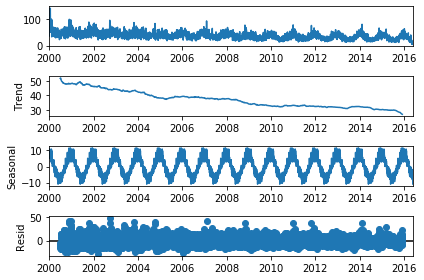

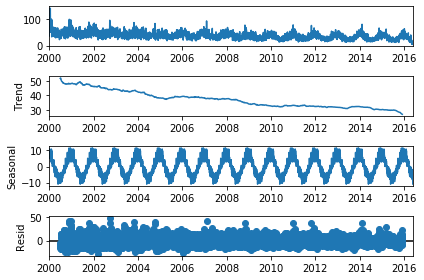

In [10]:
seasonal_decompose(df_data, model = 'additive', freq = 365).plot()

ETS(error, trend, and seasonal) model is used to visualize the data by using time series decomposition plot. Decomposition plot seperates the time series into seasonal,trend, and error components. In the fgure above, the first plot shows the actual time series, the seasonal portion shows the seasonal pattern and it is seen that seasonality occurs at regular intervals.Trend line indicates the general tendency of the time series. It is the centered moving average of time series, and fits between the seasonal peaks and valleys. This line is considered decentralized. And, lastly  is the error in the model that calculates the difference between observed value and the treadline estimate. It's the piece that's not accounted for by combining the seasonal piece and the trend piece. Making use of the ETS plot shown in decomposition plot allows us to identify the main components of time series. 

**6.3 Test stationary using Dickey-Fuller**

Before applying any statistical model on a Time Series, the series has to be staionary. Checking the stationarity of the data.
A formal way of **testing stationarity** of a dataset is using plotting the moving average or moving variance and see if the series mean and variance varies with time. The second way to test stationarity is to use the statistical test (the Dickey-Fuller Test).The null hypothesis for the test is that the time series is non-stationary. The test results compare a Test Statistic and Critical Values (cutoff value) at different confidence levels. If the ‘Test Statistic’ is less than the ‘Critical Value’, the null hypothesis is rejected and say that the series is stationary. This technique will be handled by the check_stationarity() method given below.


In [11]:
def check_stationarity(y, lags_plots=48, figsize=(22,8)):
    "Use Series as parameter"
    
    # Creating plots of the DF
    y = pd.Series(y)
    fig = plt.figure()

    ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=2)
    ax2 = plt.subplot2grid((3, 3), (1, 0))
    ax3 = plt.subplot2grid((3, 3), (1, 1))
    ax4 = plt.subplot2grid((3, 3), (2, 0), colspan=2)

    y.plot(ax=ax1, figsize=figsize)
    ax1.set_title('NO2 emission')
    plot_acf(y, lags=lags_plots, zero=False, ax=ax2);
    plot_pacf(y, lags=lags_plots, zero=False, ax=ax3);
    sns.distplot(y, bins=int(sqrt(len(y))), ax=ax4)
    ax4.set_title('Distribution Chart')

    plt.tight_layout()
    
    print('Results of Dickey-Fuller Test:')
    adfinput = adfuller(y)
    adftest = pd.Series(adfinput[0:4], index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])
    adftest = round(adftest,4)
    
    for key, value in adfinput[4].items():
        adftest["Critical Value (%s)"%key] = value.round(4)
        
    print(adftest)
    
    if adftest[0].round(2) < adftest[5].round(2):
        print('\nThe Test Statistics is lower than the Critical Value of 5%.\nThe serie seems to be stationary')
    else:
        print("\nThe Test Statistics is higher than the Critical Value of 5%.\nThe serie isn't stationary")

Results of Dickey-Fuller Test:
Test Statistic                   -5.0503
p-value                           0.0000
Lags Used                        34.0000
Number of Observations Used    5961.0000
Critical Value (1%)              -3.4314
Critical Value (5%)              -2.8620
Critical Value (10%)             -2.5670
dtype: float64

The Test Statistics is lower than the Critical Value of 5%.
The serie seems to be stationary


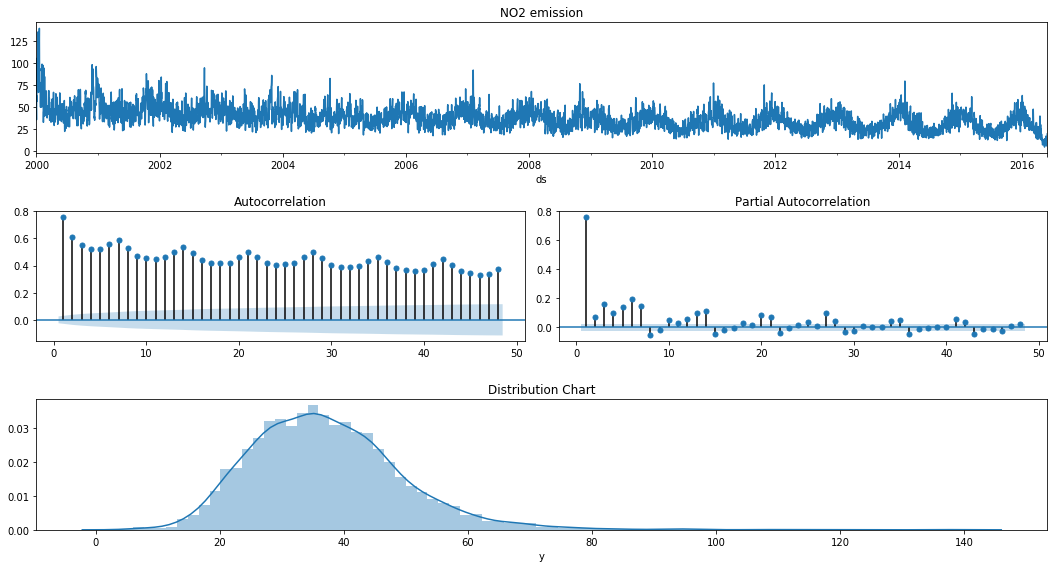

In [12]:
check_stationarity(df_data['y'])

The **autocorrelation function (ACF)** plot shows the a series correlated with itself,like by x time units. The ACF plot is used to see correlation between the points up to, and including our lag unit.This series is undifferenced and has very slow decy toward 0 correlation. Meaning that the current values are much more correlated to recent values than the values further in the past. This suggest that the series is **not stationary** and will need to be differenced to reach a stationary series.

**6.4 Differencing**

Differencing is a method of transforming a non-stationary time series to a stationary one. This is an important step in preparing data to be used in an ARIMA model. The best way to determine whether or not the series is sufficiently differenced is to plot the differenced series and check to see if there is a constant mean and variance.

In [13]:
df_data['y'].diff(7)

ds
2000-01-01          NaN
2000-01-02          NaN
2000-01-03          NaN
2000-01-04          NaN
2000-01-05          NaN
2000-01-06          NaN
2000-01-07          NaN
2000-01-08    34.875000
2000-01-09    39.125000
2000-01-10    72.473214
2000-01-11    51.295455
2000-01-12    17.833333
2000-01-13    65.768116
2000-01-14    -5.458333
2000-01-15    31.000000
2000-01-16    -1.458333
2000-01-17   -40.395833
2000-01-18     2.590909
2000-01-19    16.208334
2000-01-20   -44.416666
2000-01-21    27.291666
2000-01-22   -43.000000
2000-01-23    -4.625000
2000-01-24   -17.018940
2000-01-25   -54.594697
2000-01-26   -89.916667
2000-01-27   -31.098485
2000-01-28   -19.291666
2000-01-29    -0.541666
2000-01-30    -0.583334
                ...    
2016-05-02   -14.990000
2016-05-03    -5.620911
2016-05-04   -11.960870
2016-05-05    -8.870290
2016-05-06    -4.487122
2016-05-07    -2.119746
2016-05-08     2.783334
2016-05-09    -2.347500
2016-05-10     0.219643
2016-05-11     3.973370
2016-05-12   

Results of Dickey-Fuller Test:
Test Statistic                  -19.4219
p-value                           0.0000
Lags Used                        34.0000
Number of Observations Used    5954.0000
Critical Value (1%)              -3.4314
Critical Value (5%)              -2.8620
Critical Value (10%)             -2.5670
dtype: float64

The Test Statistics is lower than the Critical Value of 5%.
The serie seems to be stationary


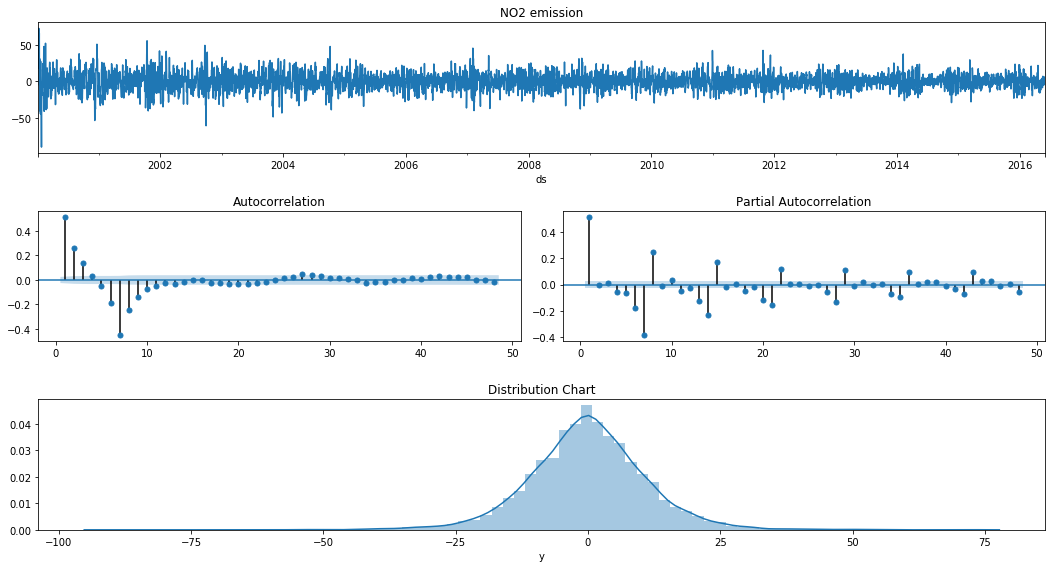

In [14]:
forecast_df = df_data.copy()
check_stationarity(forecast_df['y'].diff(7).dropna())

Now, the data seems to be stationary. Using the differencing of 365 to make the ETS plot.

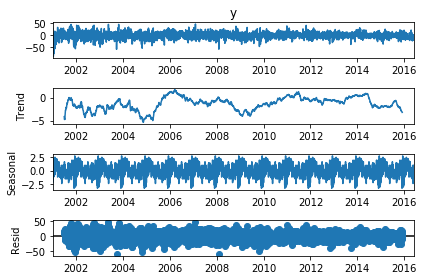

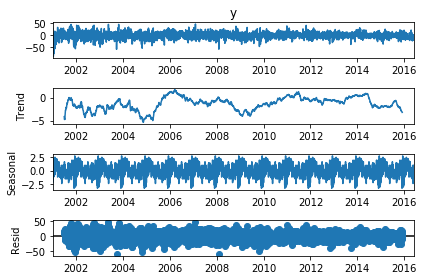

In [15]:
seasonal_decompose(forecast_df['y'].diff(365).dropna(), model = 'additive', freq = 365).plot()

Checking stationary using rolling mean as well as difference. 

In [16]:
#another way
df_grandtotal_rolling=forecast_df.diff(365).dropna().rolling(365).mean()
fig=go.Figure([go.Scatter(x=df_grandtotal_rolling.index, y=df_grandtotal_rolling['y'])])
fig.update_layout(xaxis_rangeslider_visible=True)
fig.show()

In [17]:
df_grandtotal_rolling=forecast_df.diff(365).diff(1).dropna().rolling(365).mean()
fig=go.Figure([go.Scatter(x=df_grandtotal_rolling.index, y=df_grandtotal_rolling['y'])])
fig.update_layout(xaxis_rangeslider_visible=True)
fig.show()

Results of Dickey-Fuller Test:
Test Statistic                  -22.2996
p-value                           0.0000
Lags Used                        33.0000
Number of Observations Used    5596.0000
Critical Value (1%)              -3.4315
Critical Value (5%)              -2.8621
Critical Value (10%)             -2.5670
dtype: float64

The Test Statistics is lower than the Critical Value of 5%.
The serie seems to be stationary


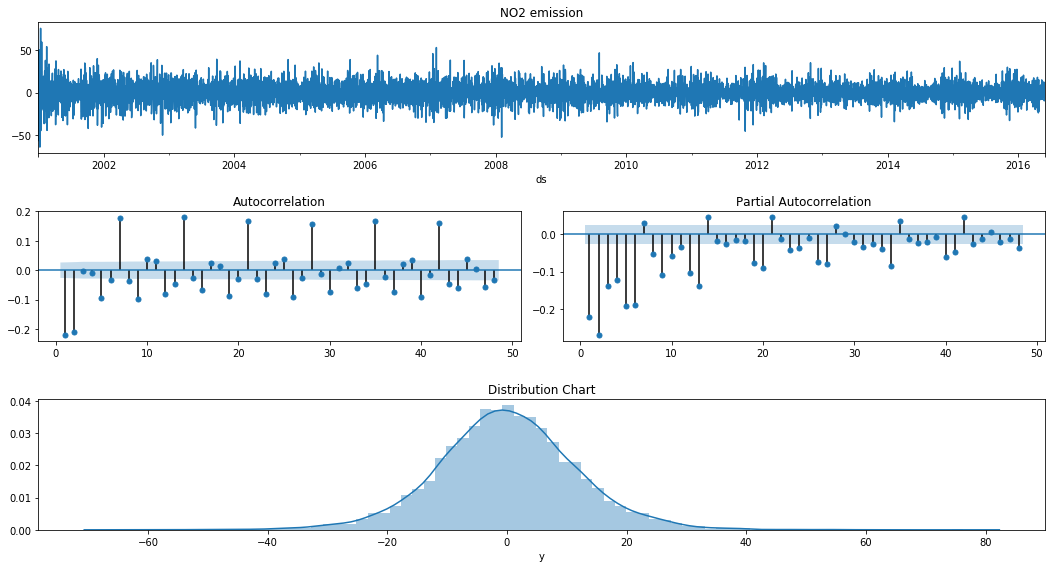

In [18]:
check_stationarity(forecast_df['y'].diff(365).diff(1).dropna())

**6.5 Plotting ACF & PACF graphs to find value of p and q**

In [19]:
diff_1_7 = forecast_df['y'].diff(7).diff(1).dropna()

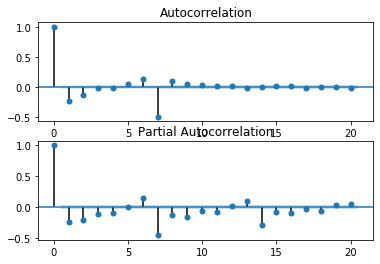

In [20]:
fig, ax = plt.subplots(2)
ax[0] = sm.graphics.tsa.plot_acf(diff_1_7, lags=20, ax=ax[0])
ax[1] = sm.graphics.tsa.plot_pacf(diff_1_7, lags=20, ax=ax[1])

**7. ARIMA Model**

ARIMA(Auto Regressive Integrated Moving Average) is a combination of 2 models AR(Auto Regressive) & MA(Moving Average). It has 3 hyperparameters - P(auto regressive lags),d(order of differentiation),Q(moving avg.) which respectively comes from the AR, I & MA components. The AR part is correlation between previous & current time periods. To smooth out the noise, the MA part is used. The I part binds together the AR & MA parts.
The predictors mainly depend on the parameters (p,d,q) of the ARIMA model:

* Number of Auto-Regressive (AR) terms (p): AR terms are just lags of dependent variable. 

* Number of Moving Average(MA) terms (q): MA terms are lagged forecast errors in prediction function. This term allows us to set the error of our model as a linear combination of the error values observed at previous time points in the past.

* Number of Differences (d): These are the number of nonseasonal differences, i.e., if we took the first order difference. So either the first order difference variable can be passed and put d=0 or  the original observed variable is passed and put d=1. Both will generate same results. This term explains the number of past time points to subtract from the current value.


**Seasonal ARIMA**

* AR (Auto Regressive): p
* I (Integrated): d
* MA (Moving Averages) q
* SAR (Seasonal Auto Regression): P
* I (Integrated): D
* SMA (Seasonal Moving Averages) Q

**7.1 Value of P & Q for ARIMA**

ACF & PACF graphs are used to find value of P & Q for ARIMA.This graph has already been made in 6.5. Now, it is necessary to check, for which value in x-axis, graph line drops to 0 in y-axis for 1st time.
From PACF(at y=0), get p
From ACF(at y=0), get q


**7.2 Grid Search**

To find the optimal parameters for ARIMA models using the graphical method is not trivial and it is time consuming so the optimal parameter values are selected systematically using the grid search (hyperparameter optimization) method. The grid search iteratively explore different combinations of the parameters. For each combination of parameters, a new seasonal ARIMA model is fitted with the SARIMAX() function from the statsmodels module and assess its overall quality.

When evaluating and comparing statistical models fitted with different parameters, each can be ranked against one another based on how well it fits the data or its ability to accurately predict future data points. Here, the AIC (Akaike Information Criterion) value is used, which is conveniently returned with ARIMA models fitted using statsmodels. The AIC measures how well a model fits the data while taking into account the overall complexity of the model. A model that fits the data very well while using lots of features will be assigned a larger AIC score than a model that uses fewer features to achieve the same goodness-of-fit. 

The order argument specifies the (p, d, q) parameters, while the seasonal_order argument specifies the (P, D, Q, S) seasonal component of the Seasonal ARIMA model. After fitting each SARIMAX()model, the code prints out its respective AIC score.

In [21]:
sarima = sm.tsa.statespace.SARIMAX(forecast_df['y'], trend='n', freq='D', enforce_invertibility=False,
                                   order=(4, 1, 0), seasonal_order=(1, 1, 0, 12))
results = sarima.fit()
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                 5996
Model:             SARIMAX(4, 1, 0)x(1, 1, 0, 12)   Log Likelihood              -22209.047
Date:                            Fri, 11 Sep 2020   AIC                          44430.095
Time:                                    16:06:25   BIC                          44470.275
Sample:                                01-01-2000   HQIC                         44444.050
                                     - 05-31-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2537      0.010    -24.771      0.000      -0.274      -0.234
ar.L2         -0.3063      0.010   

The coef column shows the weight (i.e. importance) of each feature and how each one impacts the time series. The P>|z| column informs us of the significance of each feature weight. Here, each weight has a p-value are 0, so it is reasonable to include the features in our model.

**8. Predicing value**

A model for the time series has been made that can now be used to produce forecasts. Now, comparing the predicted values to real values of the time series, which will help us understand the accuracy of the forecast. 

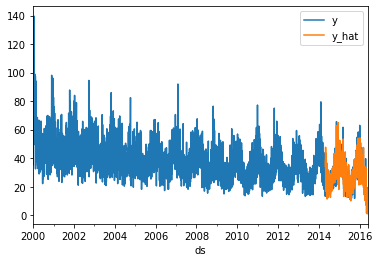

In [22]:
forecast_df['y_hat'] = results.predict(start='2014-05-01', dynamic=False)
forecast_df[['y', 'y_hat']].plot();

It is seen that the predicted forecasts are very close to the real time series values indicating a fairly accurate model.

**9. Forecasting**

In [23]:
y_hat_365 = results.predict(start='2016-02-20', end='2016-08-01', dynamic=False)

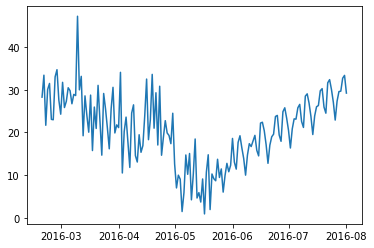

In [24]:
plt.plot(y_hat_365)

In [25]:
preds = y_hat_365.to_frame(name='y')

In [26]:
chart_df = forecast_df.tail(200)

fig = go.Figure()
fig.add_trace(go.Scatter(x=chart_df.index, y=chart_df.y, name='Real'))
fig.add_trace(go.Scatter(x=preds.index, y=preds.y, name='Prediction'))


fig.show()

The forecast generated can now be used to further explore and understand the time series. The forecast shows that the NO2 emission is expected to continue increase till January.

**10. Conclusion**

In this notebook, I have explored how to retrieve CSV dataset, how to transform the dataset into times series, testing if the time series is stationary or not using Dickey-Fuller test statistic method, how to transform time series to stationary, how to find optimal parameters to build SARIMA model using grid search method, diagnosing time series prediction, validating the predictive power, and, forecasting NO2 emission. Further, this SARIMA prediction was also compared with prophet model, and got similar prediction.

**Credits**

1. https://www.kaggle.com/search?q=arima
2. https://machinelearningmastery.com/time-series-forecasting-with-prophet-in-python/

**Dataset Source Code**
1. https://www.kaggle.com/sogun3/uspollution